In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
params = {'text.usetex': True, 'text.latex.preamble' : [r'\usepackage{amsmath}', r'\usepackage{nicefrac}']}
plt.rcParams.update(params)

In [2]:
alg_label_map = {
    'CFR+': r'$\\\text{CFR}^+$',
    'A-CFR': r'$\\\text{CFR}_{A}$',
    'A-CFR+': r'$\\\text{CFR}_{A}^+$',
    'PGPI(100/sqrt(T))': r'$\\\text{PGPI}(\nicefrac{100}{\sqrt{T}})$'
}
def alg_label(tag):
    if tag in alg_label_map:
        return alg_label_map[tag]
    return tag

In [4]:
data = pd.DataFrame.from_records(np.load('results/mal_cfr_data.npy', allow_pickle=True))
data

,game_tag,sampler,seed,mode,row_alg,col_alg,value
0,tiny_bridge,null,2.0,shuffled,CFR,CFR,20.20380
1,tiny_bridge,null,2.0,shuffled,CFR,CFR+,20.10780
2,tiny_bridge,null,2.0,shuffled,CFR,A-CFR,16.38270
3,tiny_bridge,null,2.0,shuffled,CFR,A-CFR+,16.57660
4,tiny_bridge,null,2.0,shuffled,CFR,PGPI(1),6.81434
...,...,...,...,...,...,...,...
1941,leduc,null,NaN,fixed,BR,A-CFR,1.76323
1942,leduc,null,NaN,fixed,BR,A-CFR+,1.39958
1943,leduc,null,NaN,fixed,BR,PGPI(1),1.35053
1944,leduc,null,NaN,fixed,BR,PGPI(100/sqrt(T)),1.41062


In [5]:
games = data.game_tag.unique()
games

array(['tiny_bridge', 'goofspiel', 'leduc', 'kuhn_3p', 'random_goofspiel'],
      dtype=object)

In [6]:
modes = data['mode'].unique()
modes

array(['shuffled', 'sim', 'fixed'], dtype=object)

In [33]:
def det_table(game, mode):
    assert mode == 'fixed' or mode == 'sim'
    df = data.query(f'game_tag == "{game}" & mode == "{mode}"')
    return df.pivot(index='row_alg', columns='col_alg', values='value')

def all_seeds():
    return data.seed.unique()

def shuffled_table(game, seed):
    df = data.query(f'game_tag == "{game}" & mode == "shuffled" & seed == "{seed}"')
    return df.pivot(index='row_alg', columns='col_alg', values='value')

def each_shuffled_table(game):
    for seed in all_seeds():
        yield shuffled_table(game, seed)

def shuffled_table_by_seed(game):
    df = data.query(f'game_tag == "{game}" & mode == "shuffled"')
    return df.pivot(index='seed', columns=['row_alg', 'col_alg'], values='value')
        
def max_abs_diff(game):
    df = shuffled_table_by_seed(game)
    return df.max() - df.min()

def max_abs_diff_from_mean(game):
    df = shuffled_table_by_seed(game)
    df_mean = df.mean()
    return np.maximum(df.max() - df_mean, df_mean - df.min())

def without_br_row(df):
    return df.query('row_alg != "BR"')

def br_row(df):
    return df.query('row_alg == "BR"')

def with_avg_row(df):
    row_avgs = df.mean(axis=1)
    row_avgs.name = 'avg'
    return pd.concat([df, row_avgs], axis=1)

def with_avg_row_col(df):
    col_avgs = df.mean(axis=0).to_frame('avg').transpose()
    row_avgs = df.mean(axis=1)
    row_avgs = pd.concat([row_avgs, pd.Series({'avg': row_avgs.mean()})], axis=0)
    row_avgs.name = 'avg'
    df = pd.concat([df, col_avgs], axis=0)
    return pd.concat([df, row_avgs], axis=1)

def max_element(df):
    return df.max().max().squeeze()

def min_element(df):
    return df.min().min().squeeze()

def mean_element(df):
    return df.mean().mean().squeeze()

def midpoint(df):
    return (max_element(df) - min_element(df)) / 2.0

def add_lines_to_separate_avg_row_col(axes):
    xmin, xmax = axes.get_xbound()
    ymin, ymax = axes.get_ybound()
    axes.add_line(
        mlines.Line2D([xmax - 1, xmax - 1], [ymin, ymax], color='black', linewidth=3))
    axes.add_line(
        mlines.Line2D([xmin, xmax], [ymax - 1, ymax - 1], color='black', linewidth=3))

def br_percentage_heatmap(df, ax=None, **kwargs):
    df_with_avgs = with_avg_row_col(without_br_row(df))
    df_col_mins = df_with_avgs.min(axis=0)
    df_as_frac_of_br = (df_with_avgs - df_col_mins) / (with_avg_row(br_row(df)).squeeze() - df_col_mins)
    g = sns.heatmap(
        df_as_frac_of_br,
        annot=True,
        fmt="0.2f",
        cmap=sns.color_palette("BuGn", 128),
        xticklabels=[alg_label(tag) for tag in df_with_avgs.index],
        yticklabels=[alg_label(tag) for tag in df_with_avgs.columns],
        annot_kws={'size': 'large'},
        center=0.5,
        vmin=0,
        vmax=1,
        ax=ax,
        **kwargs
    )
    g.axes.xaxis.set_ticks_position("top")
    add_lines_to_separate_avg_row_col(g.axes)
    return g

def heatmap(df, ax=None, **kwargs):
    df_with_avgs = with_avg_row_col(df)
    g = sns.heatmap(
        df_with_avgs,
        annot=True,
        fmt="0.1f",
        cmap=sns.color_palette("BrBG", 128),
        xticklabels=[alg_label(tag) for tag in df_with_avgs.index],
        yticklabels=[alg_label(tag) for tag in df_with_avgs.columns],
        annot_kws={'size': 'large'},
        center=mean_element(df),
        ax=ax,
        **kwargs
    )
    g.axes.xaxis.set_ticks_position("top")
    add_lines_to_separate_avg_row_col(g.axes)
    return g

In [8]:
print((with_avg_row_col(det_table('kuhn_3p', 'fixed')) * 1000).to_latex(float_format="{:0.1f}".format, index_names=False))

\begin{tabular}{lrrrrrrrr}
\toprule
{} &  A-CFR &  A-CFR+ &   CFR &  CFR+ &  PGPI(1) &  PGPI(100/sqrt(T)) &    PI &   avg \\
\midrule
A-CFR             &    0.0 &    -0.2 & -11.6 &  -4.0 &     74.4 &               74.4 & 315.5 &  64.1 \\
A-CFR+            &   46.7 &     0.0 &  60.1 &  -4.1 &     85.9 &               85.9 & 309.3 &  83.4 \\
BR                &  196.1 &   107.0 & 117.5 &   8.1 &    139.7 &              139.7 & 692.4 & 200.1 \\
CFR               &   58.3 &    54.8 &  -0.0 &   0.1 &    102.2 &              102.2 & 393.8 & 101.6 \\
CFR+              &  147.8 &    54.3 &  91.8 &  -0.0 &    138.4 &              138.4 & 386.3 & 136.7 \\
PGPI(1)           &    1.7 &    -2.6 &  -4.2 &  -6.7 &      0.0 &                0.0 & 332.6 &  45.8 \\
PGPI(100/sqrt(T)) &    1.7 &    -2.6 &  -4.2 &  -6.7 &      0.0 &                0.0 & 332.6 &  45.8 \\
PI                &  195.8 &   106.6 & 117.2 &   7.5 &    139.7 &              139.7 &   0.0 & 100.9 \\
avg               &   81.0 &    39

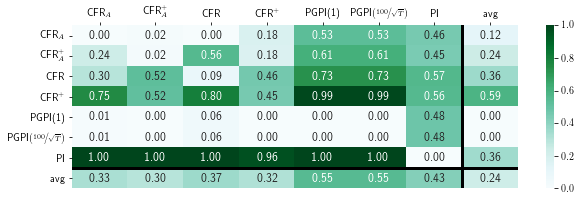

In [9]:
plt.figure(figsize=(10, 3))
br_percentage_heatmap(det_table('kuhn_3p', 'fixed'))

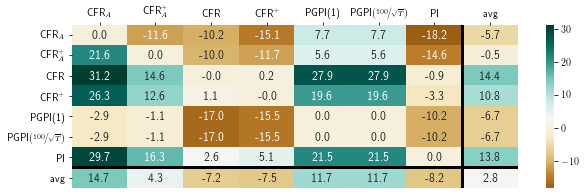

In [10]:
plt.figure(figsize=(10, 3))
heatmap(det_table('kuhn_3p', 'sim') * 1000)

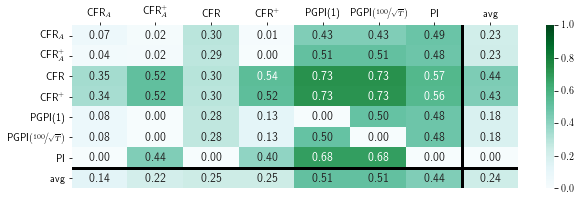

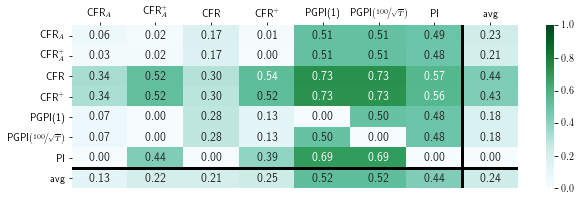

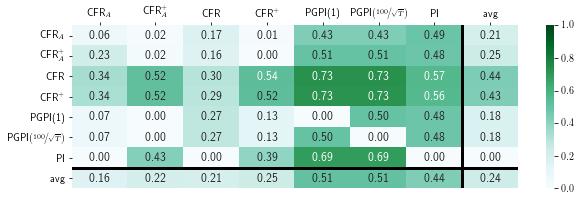

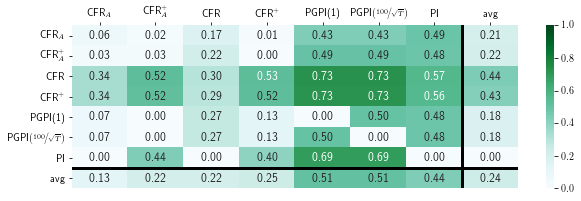

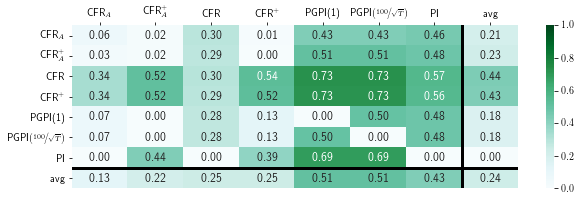

In [38]:
for seed in all_seeds():
    if not np.isnan(seed):
        plt.figure(figsize=(10, 3))
        br_percentage_heatmap(shuffled_table('kuhn_3p', seed))
        plt.show()

In [12]:
max_abs_diff("kuhn_3p") * 1000

row_alg            col_alg          
CFR                CFR                   0.000000
                   CFR+                  0.051925
                   A-CFR                 0.337800
                   A-CFR+                0.132300
                   PGPI(1)               0.213000
                   PGPI(100/sqrt(T))     0.213000
                   PI                    0.225000
CFR+               CFR                   0.311030
                   CFR+                  0.000000
                   A-CFR                 0.360200
                   A-CFR+                0.106400
                   PGPI(1)               0.124000
                   PGPI(100/sqrt(T))     0.124000
                   PI                    0.455000
A-CFR              CFR                  21.244753
                   CFR+                  0.042270
                   A-CFR                 0.000000
                   A-CFR+                0.145045
                   PGPI(1)              11.538100
             

In [26]:
max_abs_diff_from_mean("kuhn_3p") * 1000

row_alg            col_alg          
CFR                CFR                  0.000000e+00
                   CFR+                 3.006800e-02
                   A-CFR                2.002800e-01
                   A-CFR+               8.374000e-02
                   PGPI(1)              1.466000e-01
                   PGPI(100/sqrt(T))    1.466000e-01
                   PI                   1.554000e-01
CFR+               CFR                  1.650900e-01
                   CFR+                 0.000000e+00
                   A-CFR                1.872200e-01
                   A-CFR+               6.806000e-02
                   PGPI(1)              6.200000e-02
                   PGPI(100/sqrt(T))    6.200000e-02
                   PI                   2.564000e-01
A-CFR              CFR                  1.269244e+01
                   CFR+                 2.247000e-02
                   A-CFR                0.000000e+00
                   A-CFR+               8.178200e-02
         

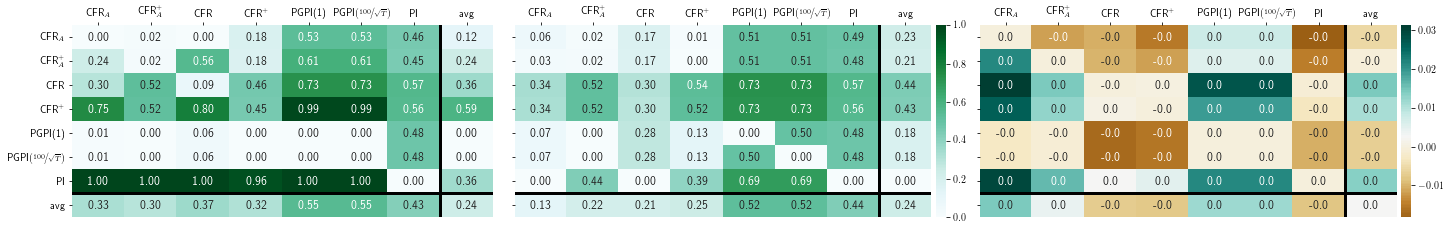

In [13]:
fig, axes_list = plt.subplots(1, 3, sharex=True, sharey=True, squeeze=False, figsize=(20, 3),
                             gridspec_kw={'width_ratios': [0.95, 1, 1]})
br_percentage_heatmap(det_table('kuhn_3p', 'fixed'), axes_list[0][0], cbar=False)
br_percentage_heatmap(shuffled_table('kuhn_3p', 1), axes_list[0][1], cbar_kws={'fraction': 0.05, 'pad': 0.01})
heatmap(without_br_row(det_table('kuhn_3p', 'sim')), axes_list[0][2], cbar_kws={'fraction': 0.05, 'pad': 0.01})
plt.tight_layout(0)
plt.subplots_adjust(
    wspace=0.05,
    hspace=0)
fig.savefig('results/heatmaps.kuhn_3p.pdf')

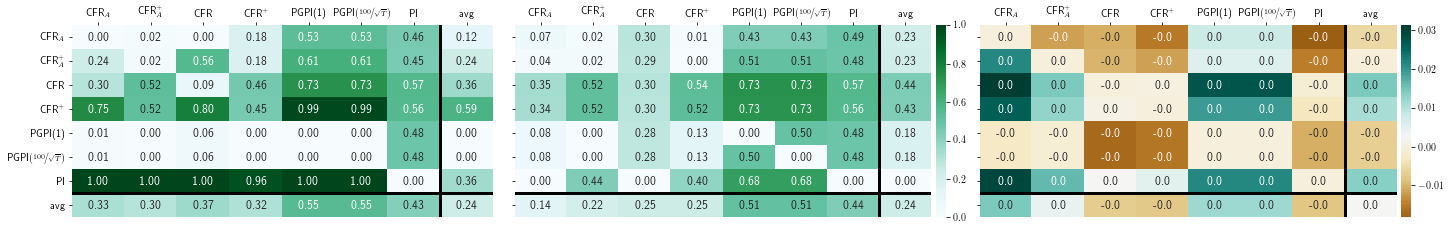

In [14]:
fig, axes_list = plt.subplots(1, 3, sharex=True, sharey=True, squeeze=False, figsize=(20, 3),
                             gridspec_kw={'width_ratios': [0.95, 1, 1]})
br_percentage_heatmap(det_table('kuhn_3p', 'fixed'), axes_list[0][0], cbar=False)
br_percentage_heatmap(shuffled_table('kuhn_3p', 2), axes_list[0][1], cbar_kws={'fraction': 0.05, 'pad': 0.01})
heatmap(without_br_row(det_table('kuhn_3p', 'sim')), axes_list[0][2], cbar_kws={'fraction': 0.05, 'pad': 0.01})
plt.tight_layout(0)
plt.subplots_adjust(
    wspace=0.05,
    hspace=0)